In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for downloading nltk data in Kaggle
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

import emoji
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import LearningCurveDisplay

# from nltk.corpus import stopwords

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [2]:
# local input
# train_data = pd.read_csv('train_dataset.csv')
# val_data = pd.read_csv('val_dataset.csv')
# test_data = pd.read_csv('test_dataset.csv')

# kaggle input
train_data = pd.read_csv('/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/train_dataset.csv')
val_data = pd.read_csv('/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/val_dataset.csv')
test_data = pd.read_csv('/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/test_dataset.csv')

## Base Case

Accuracy : 0.7909


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


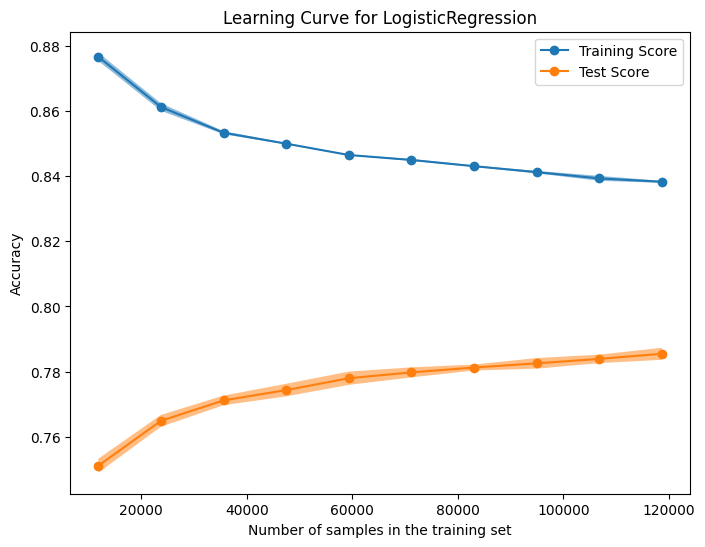

In [3]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_data['Text'])
X_val = vectorizer.transform(val_data['Text'])

model = LogisticRegression(random_state=13)
model.fit(X_train, train_data['Label'])
y_pred_val = model.predict(X_val)

accuracy = accuracy_score(val_data['Label'], y_pred_val)
print(f'Accuracy : {accuracy:.4f}')

fig, ax = plt.subplots(figsize=(8,6))

common_params = {
    "X": X_train,
    "y": train_data['Label'],
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": 5,
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(LogisticRegression(random_state=13), **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title('Learning Curve for LogisticRegression')
plt.show()

## Exploratory Data Analysis and Text Preprocessing

Each of the train, val and test dataset has an ID column which is an integer identification for each Tweet. Then we have the Text column which is the content of each Tweet. Then for the train and val datasets we also have the Label column which indicates the class the Tweet is in (0 for negative and 1 for positive)

In [4]:
print(f'Train dataset: \n{train_data.dtypes}')
print(f'{train_data.shape[0]} samples\n')
print(f'Validation dataset: \n{val_data.dtypes}')
print(f'{val_data.shape[0]} samples\n')
print(f'Test dataset: \n{test_data.dtypes}')
print(f'{test_data.shape[0]} samples\n')

Train dataset: 
ID        int64
Text     object
Label     int64
dtype: object
148388 samples

Validation dataset: 
ID        int64
Text     object
Label     int64
dtype: object
42396 samples

Test dataset: 
ID       int64
Text    object
dtype: object
21199 samples



We plot the count of each class in the train and val datasets and we see that they are balanced

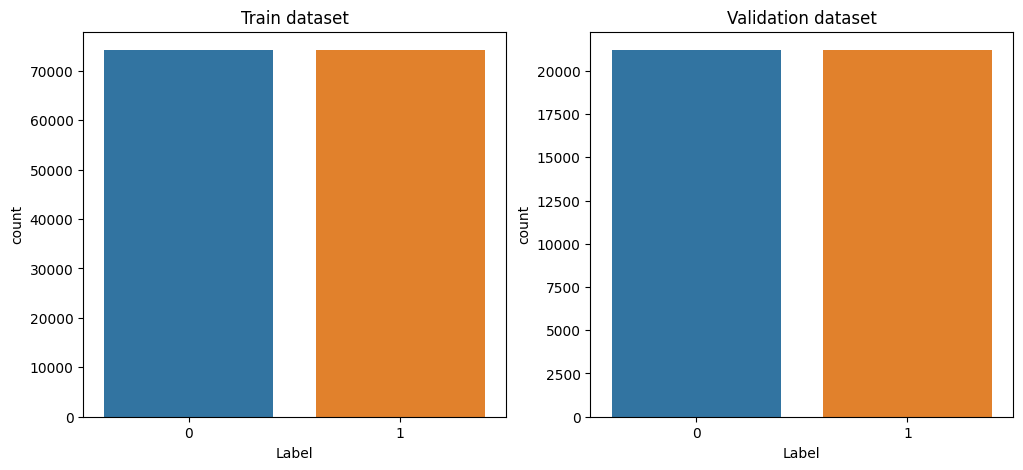

In [5]:
fig, ax= plt.subplots(1, 2, figsize = (12, 5))

c1 = sns.countplot(data=train_data, x='Label', ax=ax[0])
c1.set_title('Train dataset')
c2 = sns.countplot(data=val_data, x='Label', ax=ax[1])
c2.set_title('Validation dataset')

plt.show()

The train dataset has 234492 unique words, the val dataset has 90519 unique words, the test dataset has 53562 unique words and the complete dataset has 306856 unique words

In [6]:
def statistics(train_data, val_data, test_data):
    print('Train dataset statistics:')
    train_unique_words = {word for words in train_data['Text'].str.split() for word in words}
    print(f'Unique words: {len(train_unique_words)}')
    max_len = 0
    max_word = ''
    mean_len = 0
    for w in train_unique_words:
        mean_len += len(w)
        if len(w) > max_len:
            max_len = len(w)
            max_word = w
    mean_len = mean_len / len(train_unique_words)
    print(f'Mean word length: {mean_len}')
    print(f'Longest word length: {max_len}')
    print(f'Longest word: {max_word}')

    print('\nValidation dataset statistics:')
    val_unique_words = {word for words in val_data['Text'].str.split() for word in words}
    print(f'Unique words: {len(val_unique_words)}')
    max_len = 0
    max_word = ''
    mean_len = 0
    for w in val_unique_words:
        mean_len += len(w)
        if len(w) > max_len:
            max_len = len(w)
            max_word = w
    mean_len = mean_len / len(val_unique_words)
    print(f'Mean word length: {mean_len}')
    print(f'Longest word length: {max_len}')
    print(f'Longest word: {max_word}')

    print('\nTest dataset statistics:')
    test_unique_words = {word for words in test_data['Text'].str.split() for word in words}
    print(f'Unique words: {len(test_unique_words)}')
    max_len = 0
    max_word = ''
    mean_len = 0
    for w in test_unique_words:
        mean_len += len(w)
        if len(w) > max_len:
            max_len = len(w)
            max_word = w
    mean_len = mean_len / len(test_unique_words)
    print(f'Mean word length: {mean_len}')
    print(f'Longest word length: {max_len}')
    print(f'Longest word: {max_word}')

    train_unique_words.update(val_unique_words)
    train_unique_words.update(test_unique_words)
    print(f'\nComplete dataset unique words: {len(train_unique_words)}')

statistics(train_data, val_data, test_data)

Train dataset statistics:
Unique words: 234492
Mean word length: 9.029105470549101
Longest word length: 137
Longest word: CheeseRavioli+Zitty+Dirk+PaperAirplanes+SportsCoats+Sex+PushPlayGroupieWannabes+GirlShoes+MyspaceWhores+MakingFunOfBands+Music=GOODTIMES!

Validation dataset statistics:
Unique words: 90519
Mean word length: 8.364652724842298
Longest word length: 84
Longest word: ??????????????????????????????????????????????????????????????????????????????????..

Test dataset statistics:
Unique words: 53562
Mean word length: 8.07214069676263
Longest word length: 111
Longest word: bbbbbbbbooooooooooooooooooooooooooooooorrrrrrrrrrrrrrrrrrrrrrrrrrrrreeeeeeeeeeeeeeeeeddddddddddddddddddddddd...

Complete dataset unique words: 306856


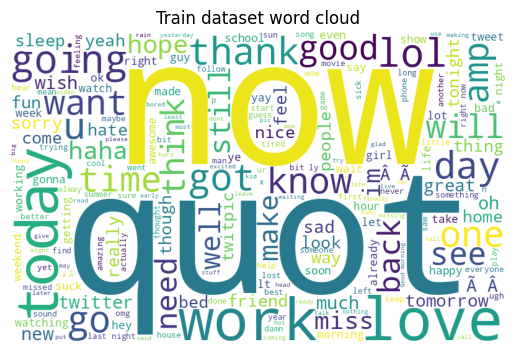

In [7]:
wc = WordCloud(background_color='white', width = 800, height = 500).generate(' '.join(train_data['Text']))
fig = plt.imshow(wc)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
fig.axes.set_frame_on(False)
fig.axes.set_title('Train dataset word cloud')
plt.show()

In [ ]:
def preprocess_text(text):
    emoticons = {
        ':)': ' smile ',
        ':-)': ' smile ',
        ':(': ' sad ',
        ':-(': ' sad ',
        ':D': ' laugh ',
        ':-D': ' laugh ',
        ':P': ' playful ',
        ':-P': ' playful ',
        ';)': ' wink ',
        ';-)': ' wink ',
        ":'(": ' cry ',
        ':-/': ' skeptical ',
        ':/': ' skeptical ',
        ':|': ' neutral ',
        ':-|': ' neutral ',
        ':O': ' surprised ',
        ':-O': ' surprised ',
        ':*': ' kiss ',
        ':-*': ' kiss ',
        'xd': ' laugh ',
    }
    def replace_emoticons(text):
        for emoticon, replacement in emoticons.items():
            text = text.replace(emoticon, replacement)
        return text
    
    text = emoji.demojize(text)
    text = replace_emoticons(text)
    
    text = text.lower()

    # remove tags, urls, html entities, emails, time
    text,_ = re.subn(r'\B@\S+', '', text)
    text,_ = re.subn(r'https?:\S+', '', text)
    text,_ = re.subn(r'www.\S+', '', text)
    text,_ = re.subn(r'&\w+;', '', text)
    text,_ = re.subn(r'\S+@\S+\.\S+', '', text)
    text,_ = re.subn(r'([0-1]?[0-9]|[2][0-3]):([0-5][0-9])0', ' time ', text)

    # remove excess letters
    pattern = re.compile(r'(.)\1{2,}')
    text = pattern.sub(r'\1\1', text)

    # replace common abbreviations and slang
    text,_ = re.subn(r'\su\s', ' you ', text)
    text,_ = re.subn(r'\bwit\b', ' with ', text)
    text,_ = re.subn(r'\bb\b', ' be ', text)
    text,_ = re.subn(r'\bxo\b', ' kiss ', text)
    text,_ = re.subn(r'\bxx\b', ' kiss ', text)
    text,_ = re.subn(r'\bluv\b', ' love ', text)
    text,_ = re.subn(r'\bpl[sz]+\b', ' please ', text)
    text,_ = re.subn(r'\b(a*ha+h[ha]*)\b', ' laugh ', text)
    text,_ = re.subn(r'\b(o?l+o+l+[ol]*)\b', ' lol ', text)
    text,_ = re.subn(r'\b(?=lmao)\S*(\S+)(?<=\blmao)\1*\b', ' lol ', text)
    text,_ = re.subn(r'\b(?=omg)\S*(\S+)(?<=\bomg)\1*\b', ' omg ', text)

    # remove stopwords
    # stop_words = set(stopwords.words('english'))
    # text = ' '.join([word for word in text.split() if word not in stop_words])
    # remove contractions
    # text,_ = re.subn(r'\bm\b', '', text)
    # text,_ = re.subn(r'\bs\b', '', text)
    # text,_ = re.subn(r'\bre\b', '', text)
    # text,_ = re.subn(r'\bll\b', '', text)
    # text,_ = re.subn(r'\bt\b', '', text)
    # remove numbers
    # text,_ = re.subn(r'\b\d+\b', '', text)

    text,_ = re.subn(r'[^\w\s]',' ', text)
    text,_ = re.subn(r'\s+', ' ', text)
    
    text = WordNetLemmatizer().lemmatize(text)

    return text

train_data['Text'] = train_data['Text'].apply(preprocess_text)
val_data['Text'] = val_data['Text'].apply(preprocess_text)
test_data['Text'] = test_data['Text'].apply(preprocess_text)

statistics(train_data, val_data, test_data)

Train dataset statistics:
Unique words: 71224
Mean word length: 6.631739301359093
Longest word length: 103
Longest word: youthinkimkiddingimfuckingseriousiamhavingmeatloafwithdrawalsandamthisclosetorobbingameatloafrestaurant

Validation dataset statistics:
Unique words: 33253
Mean word length: 6.4205635581752025
Longest word length: 40
Longest word: whyareallthegoodmedscontrolledsubstances

Test dataset statistics:
Unique words: 21858
Mean word length: 6.278891023881417
Longest word length: 45
Longest word: unfollowanyonewhoisfollowingoprahcampaign2009

Complete dataset unique words: 88998


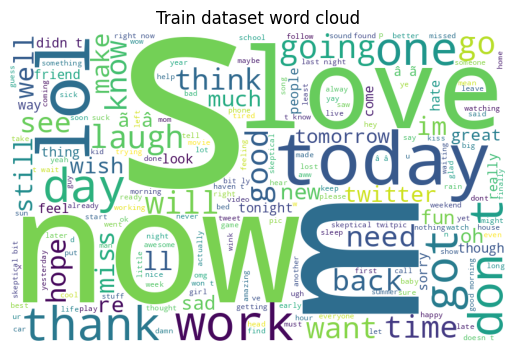

In [9]:
wc = WordCloud(background_color='white', width = 800, height = 500).generate(' '.join(train_data['Text']))
fig = plt.imshow(wc)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
fig.axes.set_frame_on(False)
fig.axes.set_title('Train dataset word cloud')
plt.show()

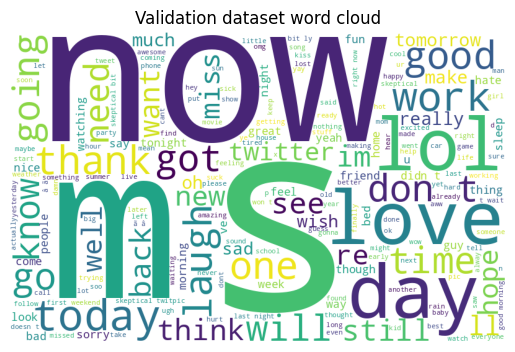

In [10]:
wc = WordCloud(background_color='white', width = 800, height = 500).generate(' '.join(val_data['Text']))
fig = plt.imshow(wc)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
fig.axes.set_frame_on(False)
fig.axes.set_title('Validation dataset word cloud')
plt.show()

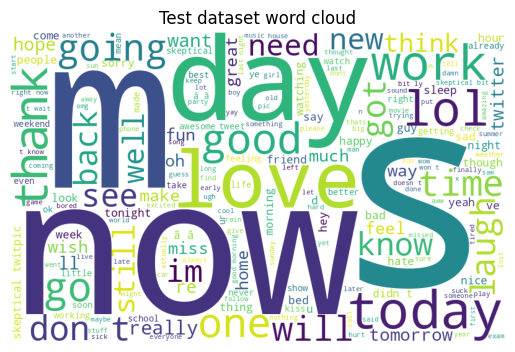

In [11]:
wc = WordCloud(background_color='white', width = 800, height = 500).generate(' '.join(test_data['Text']))
fig = plt.imshow(wc)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
fig.axes.set_frame_on(False)
fig.axes.set_title('Test dataset word cloud')
plt.show()

## Feature Extraction

In [12]:
vectorizer = TfidfVectorizer(analyzer='word', tokenizer=TweetTokenizer().tokenize, ngram_range=(1,2), token_pattern=None)
X_train = vectorizer.fit_transform(train_data['Text'])
X_val = vectorizer.transform(val_data['Text'])
X_test = vectorizer.transform(test_data['Text'])

## Model Development and Evaluation

In [ ]:
# Code for hyperparameter tuning

# param_grid = {
#     'C': [float(i) for i in np.arange(1.5, 3, 0.2)],
#     'solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']
# }

# grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=13), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search.fit(X_train, train_data['Label'])
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print(best_score, best_params)

In [ ]:
best_params = {'C': 2.3, 'solver': 'lbfgs'} # Hard coded best params

model = LogisticRegression(max_iter=1000, random_state=13, C=best_params['C'], solver=best_params['solver'])
model.fit(X_train, train_data['Label'])
y_pred_val = model.predict(X_val)
y_pred_prob = model.predict_proba(X_val)[:,1]
y_pred = model.predict(X_test)

accuracy = accuracy_score(val_data['Label'], y_pred_val)
print(f'Accuracy : {accuracy:.4f}')
recall = recall_score(val_data['Label'], y_pred_val)
print(f'Recall : {recall:.4f}')
precision = precision_score(val_data['Label'], y_pred_val)
print(f'Precision : {precision:.4f}')
f1 = f1_score(val_data['Label'], y_pred_val)
print(f'F1 : {f1:.4f}')
print(confusion_matrix(val_data['Label'], y_pred_val))

output = pd.DataFrame(test_data['ID'])
output['Label'] = y_pred
output.to_csv('submission.csv', index=False)

Accuracy : 0.8085
Recall : 0.8026
Precision : 0.8121
F1 : 0.8074
[[17261  3936]
 [ 4184 17015]]


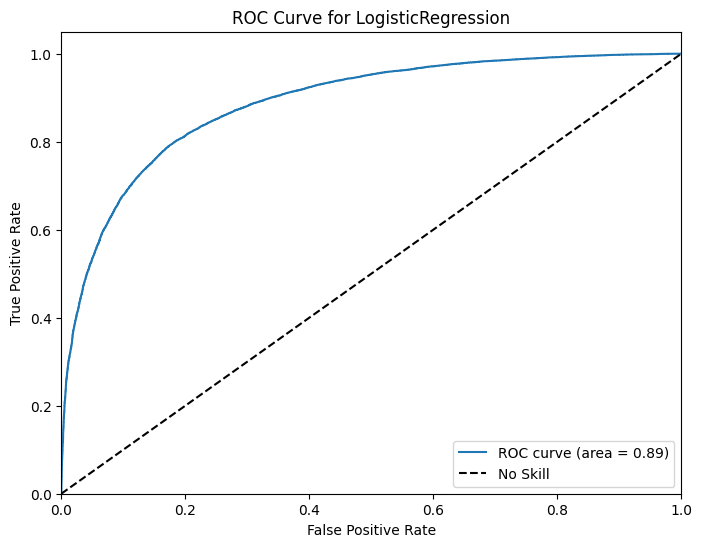

In [15]:
fig, ax = plt.subplots(figsize=(8,6))

fpr, tpr, thresholds = roc_curve(val_data['Label'], y_pred_prob) 
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LogisticRegression')
plt.legend(loc='lower right')
plt.show()

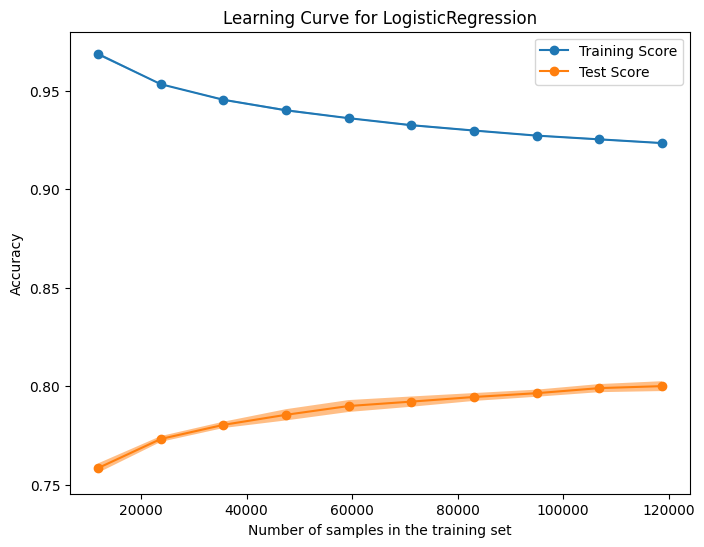

In [16]:
fig, ax = plt.subplots(figsize=(8,6))

common_params = {
    "X": X_train,
    "y": train_data['Label'],
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": 5,
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(LogisticRegression(max_iter=1000, random_state=13, C=best_params['C'], solver=best_params['solver']), **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title('Learning Curve for LogisticRegression')
plt.show()